# Discretization with decision trees

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor, plot_tree

In [2]:
# load the California House price data from Scikit-learn
X, y = fetch_california_housing(return_X_y=True, as_frame=True)

# display top 5 rows
X.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25


In [3]:
# let's separate the data into training and testing sets

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.3,
    random_state=0,
)

X_train.shape, X_test.shape

((14448, 8), (6192, 8))

# Discretization using Decision Trees

In [4]:
# example: build Regression tree using MedInc to predict house price

tree_model = DecisionTreeRegressor(max_depth=3, random_state=0)

tree_model.fit(X_train["MedInc"].to_frame(), y_train)

DecisionTreeRegressor(max_depth=3, random_state=0)

In [5]:
# create features with output of decision tree

X_train["MedInc_tree"] = tree_model.predict(X_train["MedInc"].to_frame())
X_test["MedInc_tree"] = tree_model.predict(X_test["MedInc"].to_frame())

In [6]:
# let's explore the number of unique values in
# our "discrete" variable

X_test["MedInc_tree"].nunique()

8

In [7]:
# let's explore the unique values

X_test["MedInc_tree"].unique()

array([2.27113313, 2.76842266, 1.51756502, 3.46323449, 1.91725491,
       1.14863215, 4.31789332, 4.87645172])

Text(0, 0.5, 'Median Price')

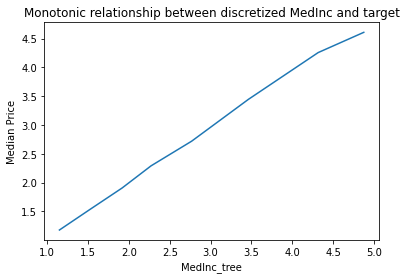

In [8]:
# monotonic relationship with target: test set

y_test.groupby(X_test["MedInc_tree"]).mean().plot()
plt.title("Monotonic relationship between discretized MedInc and target")
plt.ylabel("Median Price")

Text(0, 0.5, 'Number of observations')

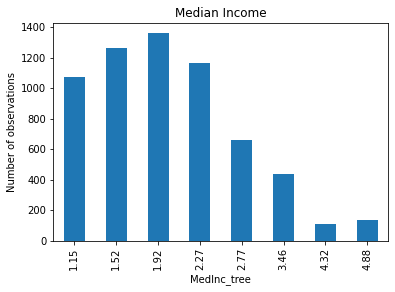

In [9]:
# plot number of observations per "bin"

X_test["MedInc_tree"] = np.round(X_test["MedInc_tree"], 2)
X_test.groupby(["MedInc_tree"])["MedInc"].count().plot.bar()
plt.title("Median Income")
plt.ylabel("Number of observations")

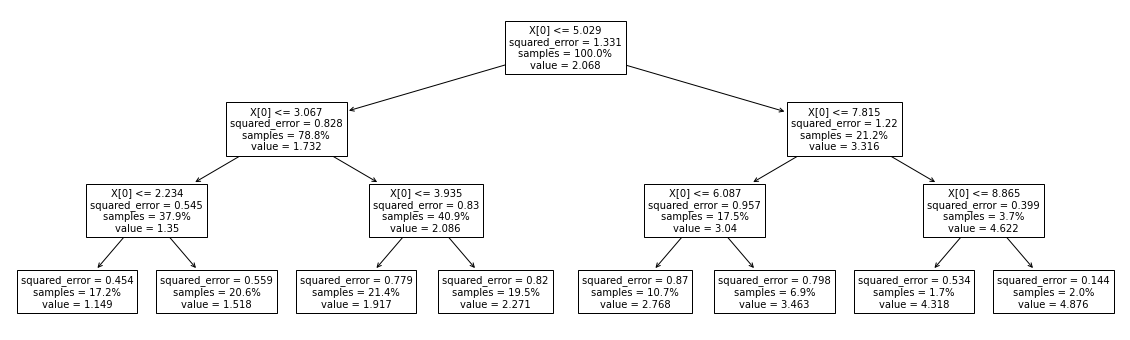

In [10]:
# let's analyize the decision tree

fig = plt.figure(figsize=(20, 6))
plot_tree(tree_model, fontsize=10, proportion=True)
plt.show()

# Decision tree discretization with Feature-engine

In [11]:
from feature_engine.discretisation import DecisionTreeDiscretiser

In [12]:
# let's separate into training and testing set

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.3,
    random_state=0,
)

In [13]:
variables = list(X.columns)[:-2]

variables

['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population', 'AveOccup']

In [14]:
# set up the decision tree discretiser indicating:

# cross-validation fold (cv)
# the metric to evaluate model performance (scoring)
# the variables we want to discretise (variables)
# whether it is a target for regression or classification
# and the grid with hyperparameters to optimize the decision tree

treeDisc = DecisionTreeDiscretiser(
    cv=3,
    scoring="neg_mean_squared_error",
    variables=variables,
    regression=True,
    param_grid={"max_depth": [1, 2, 3], "min_samples_leaf": [10, 20, 50]},
)

treeDisc.fit(X_train, y_train)

DecisionTreeDiscretiser(param_grid={'max_depth': [1, 2, 3],
                                    'min_samples_leaf': [10, 20, 50]},
                        variables=['MedInc', 'HouseAge', 'AveRooms',
                                   'AveBedrms', 'Population', 'AveOccup'])

In [15]:
# we can inspect the best parameters found for the tree for MedInc

treeDisc.binner_dict_["MedInc"].best_params_

{'max_depth': 3, 'min_samples_leaf': 10}

In [16]:
# the scores for the tree here

treeDisc.scores_dict_["MedInc"]

-0.679677058132483

In [17]:
# let's transform the data

train_t = treeDisc.transform(X_train)
test_t = treeDisc.transform(X_test)

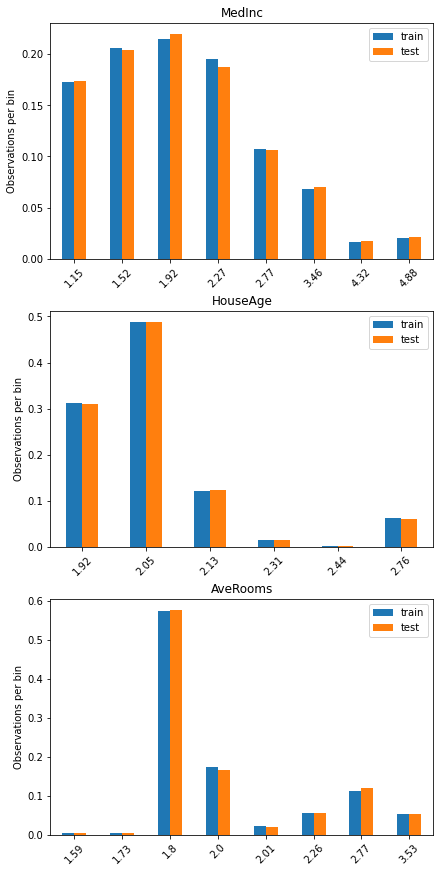

In [18]:
# Let's plot 3 variables:

plt.figure(figsize=(6, 12), constrained_layout=True)

for i in range(3):

    # location in figure
    ax = plt.subplot(3, 1, i + 1)

    # variable to plot
    var = variables[i]

    train_t[var] = np.round(train_t[var], 2)
    test_t[var] = np.round(test_t[var], 2)

    # determine proportion of observations per bin
    t1 = train_t[var].value_counts(normalize=True)
    t2 = test_t[var].value_counts(normalize=True)

    # concatenate proportions
    tmp = pd.concat([t1, t2], axis=1)
    tmp.columns = ["train", "test"]

    # order the intervals
    tmp.sort_index(inplace=True)

    tmp.plot.bar(ax=ax)
    plt.xticks(rotation=45)
    plt.ylabel("Observations per bin")

    # add variable name as title
    ax.set_title(var)

plt.show()